In [9]:
%pylab inline
import pandas as pd
import numpy as np
import pickle

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.preprocessing import text, sequence
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

Populating the interactive namespace from numpy and matplotlib


C:\Users\Yunkun\AppData\Local\conda\conda\envs\deeplearning\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
train = pd.read_csv("./input/train.csv")
test  = pd.read_csv("./input/test.csv")

list_sentences_train = train["comment_text"].fillna(" ").values
list_sentences_test = test["comment_text"].fillna(" ").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

In [4]:
max_features = 20000
maxlen = 100

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

X_train = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

In [5]:
def get_model():
    embed_size = 64
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model



In [6]:
model = get_model()

batch_size = 32
epochs = 2

file_path="weights_base_orig.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=20)
callbacks_list = [checkpoint, early] 

#model.load_weights(file_path)
history = model.fit(X_train, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks_list)



Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143584/143613 [============================>.] - ETA: 0s - loss: 0.0654 - acc: 0.9788
Epoch 00001: val_loss improved from inf to 0.05002, saving model to weights_base_orig.best.hdf5
143613/143613 [==============================] - 1391s 10ms/step - loss: 0.0654 - acc: 0.9788 - val_loss: 0.0500 - val_acc: 0.9819
Epoch 2/2
143584/143613 [============================>.] - ETA: 0s - loss: 0.0466 - acc: 0.9830
Epoch 00002: val_loss improved from 0.05002 to 0.04894, saving model to weights_base_orig.best.hdf5
143613/143613 [==============================] - 1382s 10ms/step - loss: 0.0466 - acc: 0.9830 - val_loss: 0.0489 - val_acc: 0.9824


In [7]:
print(history.history.keys())

dict_keys(['val_acc', 'acc', 'loss', 'val_loss'])


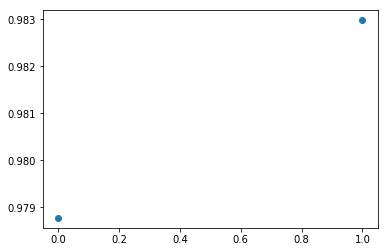

In [10]:
plot(history.history['acc'],'o')

with open('./trainHistoryDict', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
model.load_weights(file_path)
y_test = model.predict(X_test)


In [ ]:
sample_submission = pd.read_csv("./input/sample_submission.csv")
sample_submission[list_classes] = y_test
sample_submission.to_csv("baseline.csv", index=False)